## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
import scipy.sparse as sp
from numba import jit
import squidpy as sq
import models
from sklearn.metrics import accuracy_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
adata = sq.datasets.seqfish()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata


AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined', 'n_counts'
    uns: 'celltype_mapped_refined_colors', 'log1p'
    obsm: 'X_umap', 'spatial'

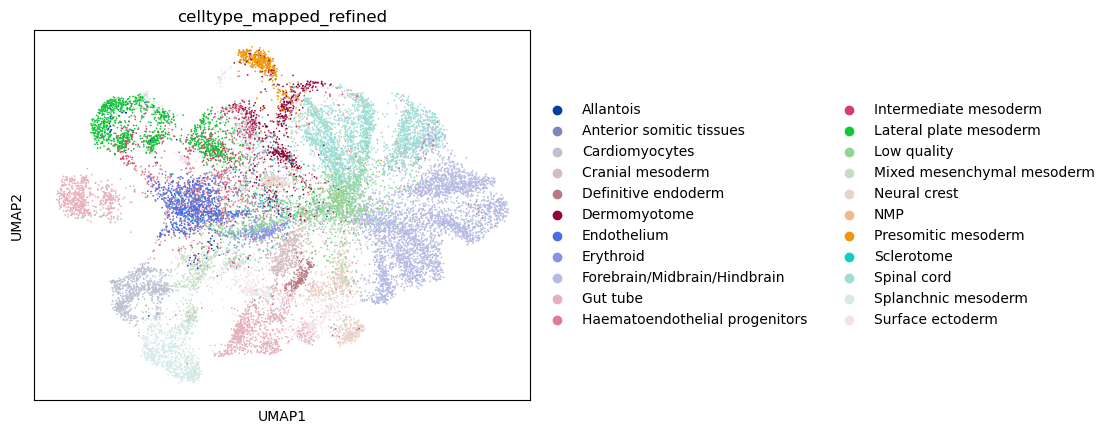

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype_mapped_refined')

In [4]:
adata.obs['CellType']= adata.obs['celltype_mapped_refined']
celltype_list = list(adata.obs['CellType'].unique())
celltype_list.remove("Low quality")
len(celltype_list)

21

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


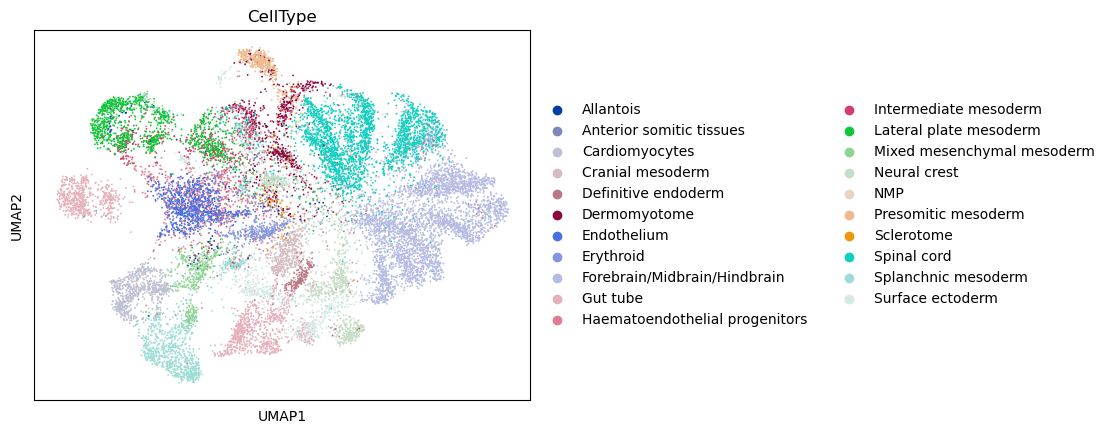

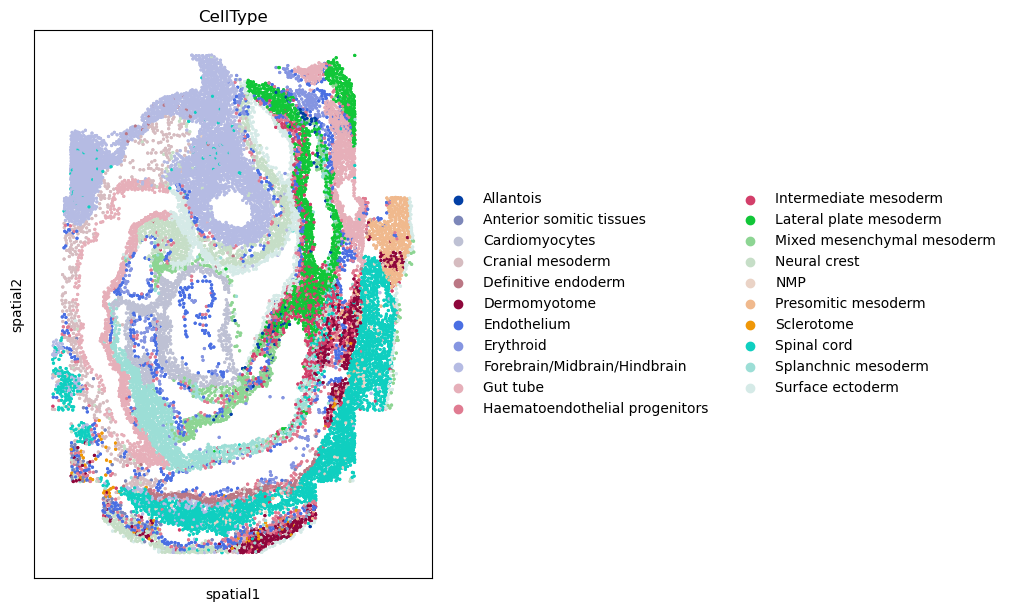

In [5]:
adata= adata[adata.obs['CellType'].isin(celltype_list)]
sc.pl.umap(adata,color='CellType')
sq.pl.spatial_scatter(
    adata, color="CellType", shape=None, figsize=(10, 10)
)


In [6]:
adata

AnnData object with n_obs × n_vars = 17771 × 351
    obs: 'Area', 'celltype_mapped_refined', 'n_counts', 'CellType'
    uns: 'celltype_mapped_refined_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'X_umap', 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder



In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


def multi_ada_sampling(data, label, classifier="svm", percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return data[:, idx], label[idx]

    models = []
    for _ in range(L):
        X = data
        Y = label
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            if classifier == "rf":
                model = RandomForestClassifier(n_estimators=100)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier == "svm":
                model = SVC(probability=True)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier =="knn":
                model = KNeighborsClassifier()
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
                #print(prob)
            else:
                raise ValueError(f"Unknown classifier: {classifier}")
            
            X, Y = [], []
            xy_update = []
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                xy_update.append(update_xy(vote_class, label, percent, balance))
            
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            X, Y = cur_X, cur_Y
        models.append(model)
    
    predict_mat = np.zeros((data.shape[1], len(np.unique(label))))
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        predict_mat += tmp
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return {"final": final, "models": models, "prob": predict_mat}

def get_conf_from_scReClassify(adata, res , formerlabels, L=10):
    prob_mat= res['prob']
    return prob_mat[np.arange(len(prob_mat)), formerlabels]/L



In [9]:
adata.X = adata.X.toarray()

In [10]:
#epoch_num=25

#prob_list = models.follow_training_dyn_neural_net(adata, label_key='CellType',iterNum=epoch_num, device=device)
#all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
#adata.obs['conf']= all_conf
#adata.obs['var']= all_var
#cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'CellType',device=device,probability=0.01,percentile=95,epoch_num=epoch_num)
#adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))


In [11]:
#cutoff_conf , cutoff_var

In [12]:
#adata= adata[adata.obs['conf_binaries'].isin([True])]
#adata

In [13]:
adata_copy = adata.copy()


In [14]:
from sklearn.preprocessing import LabelEncoder
epoch_num=20



from sklearn.preprocessing import LabelEncoder
screc_res_list_rf = []
screc_res_list_svm = []
screc_res_list_knn = []
cell_anno_list = []
screc_res_list_rf_var = []
screc_res_list_knn_var = []
screc_res_list_svm_var = []
cell_anno_list_var = []
for i in range(1,6):
    tmp_roc_screc_rf = []
    tmp_roc_screc_knn = []
    tmp_roc_screc_svm = []
    tmp_roc_cell_anno = []
    for j in range(10):
        adata= adata_copy.copy()
        sc.pp.subsample(adata, n_obs=10000)
        labeles = adata.obs['CellType']
        df , were_changed = modify_labels(labeles , probability=0.1*i)
        were_changed_array =np.zeros(adata.n_obs)
        were_changed_array[were_changed]=1
        adata.obs['former_labels']=df['label']
        adata.obs['new_labels']=df['modified_label']
        adata.obs['new_labels']
        le = LabelEncoder()
        le.fit(adata.obs['new_labels'])

        mod_labels= le.transform(adata.obs['new_labels'])
        former_labels= le.transform(adata.obs['former_labels'])
        
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="knn")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_knn.append(roc_auc_score(1-were_changed_array, conf))

        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="rf")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_rf.append(roc_auc_score(1-were_changed_array, conf))
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="svm")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_svm.append(roc_auc_score(1-were_changed_array, conf))
        prob_list = models.follow_training_dyn_neural_net(adata, label_key='new_labels',iterNum=epoch_num, device=device, batch_size=64)
        all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
        tmp_roc_cell_anno.append(roc_auc_score(1-were_changed_array, all_conf))
        print(tmp_roc_screc_knn)
        print(tmp_roc_screc_rf)
        print(tmp_roc_screc_svm)
        print(tmp_roc_cell_anno)
    screc_res_list_knn.append(np.mean(tmp_roc_screc_knn))
    screc_res_list_rf.append(np.mean(tmp_roc_screc_rf))
    screc_res_list_svm.append(np.mean(tmp_roc_screc_svm))
    cell_anno_list.append(np.mean(tmp_roc_cell_anno))
    screc_res_list_rf_var.append(np.var(tmp_roc_screc_rf))
    screc_res_list_svm_var.append(np.var(tmp_roc_screc_svm))
    cell_anno_list_var.append(np.var(tmp_roc_cell_anno))
    screc_res_list_knn_var.append(np.var(tmp_roc_screc_knn))



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.606
[1,    12] loss: 3.060
[1,    22] loss: 3.052
[1,    32] loss: 3.041
[1,    42] loss: 3.034
[1,    52] loss: 3.018
[1,    62] loss: 3.005
[1,    72] loss: 3.005
[1,    82] loss: 2.992
[1,    92] loss: 2.978
[1,   102] loss: 2.973
[1,   112] loss: 2.958
[1,   122] loss: 2.959
[1,   132] loss: 2.933
[1,   142] loss: 2.916
[1,   152] loss: 2.893
[2,     2] loss: 0.581
[2,    12] loss: 2.848
[2,    22] loss: 2.849
[2,    32] loss: 2.816
[2,    42] loss: 2.794
[2,    52] loss: 2.775
[2,    62] loss: 2.738
[2,    72] loss: 2.725
[2,    82] loss: 2.668
[2,    92] loss: 2.646
[2,   102] loss: 2.616
[2,   112] loss: 2.577
[2,   122] loss: 2.519
[2,   132] loss: 2.469
[2,   142] loss: 2.418
[2,   152] loss: 2.357
[3,     2] loss: 0.455
[3,    12] loss: 2.255
[3,    22] loss: 2.302
[3,    32] loss: 2.209
[3,    42] loss: 2.109
[3,    52] loss: 2.138
[3,    62] loss: 2.030
[3,    72] loss: 2.042
[3,    82] loss: 2.039
[3,    92] loss: 2.048
[3,   102] loss: 2.020
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.088
[1,    22] loss: 3.079
[1,    32] loss: 3.060
[1,    42] loss: 3.042
[1,    52] loss: 3.038
[1,    62] loss: 3.030
[1,    72] loss: 3.010
[1,    82] loss: 3.003
[1,    92] loss: 2.989
[1,   102] loss: 2.995
[1,   112] loss: 2.977
[1,   122] loss: 2.955
[1,   132] loss: 2.952
[1,   142] loss: 2.929
[1,   152] loss: 2.922
[2,     2] loss: 0.577
[2,    12] loss: 2.882
[2,    22] loss: 2.866
[2,    32] loss: 2.863
[2,    42] loss: 2.832
[2,    52] loss: 2.804
[2,    62] loss: 2.796
[2,    72] loss: 2.758
[2,    82] loss: 2.752
[2,    92] loss: 2.701
[2,   102] loss: 2.682
[2,   112] loss: 2.676
[2,   122] loss: 2.640
[2,   132] loss: 2.571
[2,   142] loss: 2.554
[2,   152] loss: 2.489
[3,     2] loss: 0.495
[3,    12] loss: 2.451
[3,    22] loss: 2.441
[3,    32] loss: 2.365
[3,    42] loss: 2.298
[3,    52] loss: 2.300
[3,    62] loss: 2.187
[3,    72] loss: 2.214
[3,    82] loss: 2.143
[3,    92] loss: 2.117
[3,   102] loss: 2.105
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.060
[1,    22] loss: 3.050
[1,    32] loss: 3.024
[1,    42] loss: 3.020
[1,    52] loss: 3.009
[1,    62] loss: 2.986
[1,    72] loss: 2.962
[1,    82] loss: 2.954
[1,    92] loss: 2.945
[1,   102] loss: 2.918
[1,   112] loss: 2.932
[1,   122] loss: 2.887
[1,   132] loss: 2.860
[1,   142] loss: 2.838
[1,   152] loss: 2.854
[2,     2] loss: 0.551
[2,    12] loss: 2.761
[2,    22] loss: 2.763
[2,    32] loss: 2.736
[2,    42] loss: 2.713
[2,    52] loss: 2.661
[2,    62] loss: 2.599
[2,    72] loss: 2.586
[2,    82] loss: 2.538
[2,    92] loss: 2.493
[2,   102] loss: 2.439
[2,   112] loss: 2.394
[2,   122] loss: 2.409
[2,   132] loss: 2.357
[2,   142] loss: 2.314
[2,   152] loss: 2.281
[3,     2] loss: 0.453
[3,    12] loss: 2.182
[3,    22] loss: 2.137
[3,    32] loss: 2.059
[3,    42] loss: 2.064
[3,    52] loss: 2.012
[3,    62] loss: 1.891
[3,    72] loss: 2.021
[3,    82] loss: 1.943
[3,    92] loss: 1.883
[3,   102] loss: 1.848
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.621
[1,    12] loss: 3.064
[1,    22] loss: 3.069
[1,    32] loss: 3.049
[1,    42] loss: 3.045
[1,    52] loss: 3.037
[1,    62] loss: 3.016
[1,    72] loss: 3.007
[1,    82] loss: 2.987
[1,    92] loss: 2.994
[1,   102] loss: 2.964
[1,   112] loss: 2.961
[1,   122] loss: 2.948
[1,   132] loss: 2.920
[1,   142] loss: 2.910
[1,   152] loss: 2.904
[2,     2] loss: 0.579
[2,    12] loss: 2.900
[2,    22] loss: 2.864
[2,    32] loss: 2.836
[2,    42] loss: 2.789
[2,    52] loss: 2.794
[2,    62] loss: 2.739
[2,    72] loss: 2.752
[2,    82] loss: 2.691
[2,    92] loss: 2.678
[2,   102] loss: 2.660
[2,   112] loss: 2.594
[2,   122] loss: 2.554
[2,   132] loss: 2.558
[2,   142] loss: 2.462
[2,   152] loss: 2.440
[3,     2] loss: 0.467
[3,    12] loss: 2.401
[3,    22] loss: 2.318
[3,    32] loss: 2.278
[3,    42] loss: 2.271
[3,    52] loss: 2.213
[3,    62] loss: 2.197
[3,    72] loss: 2.136
[3,    82] loss: 2.085
[3,    92] loss: 2.069
[3,   102] loss: 1.975
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.051
[1,    22] loss: 3.050
[1,    32] loss: 3.037
[1,    42] loss: 3.009
[1,    52] loss: 2.993
[1,    62] loss: 2.975
[1,    72] loss: 2.965
[1,    82] loss: 2.939
[1,    92] loss: 2.933
[1,   102] loss: 2.912
[1,   112] loss: 2.877
[1,   122] loss: 2.866
[1,   132] loss: 2.841
[1,   142] loss: 2.809
[1,   152] loss: 2.776
[2,     2] loss: 0.548
[2,    12] loss: 2.749
[2,    22] loss: 2.709
[2,    32] loss: 2.667
[2,    42] loss: 2.624
[2,    52] loss: 2.574
[2,    62] loss: 2.519
[2,    72] loss: 2.479
[2,    82] loss: 2.466
[2,    92] loss: 2.400
[2,   102] loss: 2.345
[2,   112] loss: 2.315
[2,   122] loss: 2.245
[2,   132] loss: 2.211
[2,   142] loss: 2.156
[2,   152] loss: 2.124
[3,     2] loss: 0.412
[3,    12] loss: 2.012
[3,    22] loss: 2.044
[3,    32] loss: 1.889
[3,    42] loss: 1.931
[3,    52] loss: 1.935
[3,    62] loss: 1.887
[3,    72] loss: 1.840
[3,    82] loss: 1.792
[3,    92] loss: 1.813
[3,   102] loss: 1.755
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.053
[1,    22] loss: 3.056
[1,    32] loss: 3.028
[1,    42] loss: 3.031
[1,    52] loss: 3.005
[1,    62] loss: 2.992
[1,    72] loss: 2.980
[1,    82] loss: 2.972
[1,    92] loss: 2.937
[1,   102] loss: 2.934
[1,   112] loss: 2.917
[1,   122] loss: 2.899
[1,   132] loss: 2.883
[1,   142] loss: 2.875
[1,   152] loss: 2.834
[2,     2] loss: 0.563
[2,    12] loss: 2.791
[2,    22] loss: 2.798
[2,    32] loss: 2.750
[2,    42] loss: 2.714
[2,    52] loss: 2.687
[2,    62] loss: 2.626
[2,    72] loss: 2.571
[2,    82] loss: 2.582
[2,    92] loss: 2.506
[2,   102] loss: 2.476
[2,   112] loss: 2.422
[2,   122] loss: 2.400
[2,   132] loss: 2.301
[2,   142] loss: 2.329
[2,   152] loss: 2.214
[3,     2] loss: 0.440
[3,    12] loss: 2.205
[3,    22] loss: 2.202
[3,    32] loss: 2.129
[3,    42] loss: 2.067
[3,    52] loss: 2.014
[3,    62] loss: 1.989
[3,    72] loss: 1.909
[3,    82] loss: 1.921
[3,    92] loss: 1.953
[3,   102] loss: 1.839
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.059
[1,    22] loss: 3.046
[1,    32] loss: 3.037
[1,    42] loss: 3.023
[1,    52] loss: 3.020
[1,    62] loss: 3.003
[1,    72] loss: 2.991
[1,    82] loss: 2.980
[1,    92] loss: 2.966
[1,   102] loss: 2.950
[1,   112] loss: 2.940
[1,   122] loss: 2.919
[1,   132] loss: 2.911
[1,   142] loss: 2.874
[1,   152] loss: 2.865
[2,     2] loss: 0.563
[2,    12] loss: 2.822
[2,    22] loss: 2.797
[2,    32] loss: 2.755
[2,    42] loss: 2.738
[2,    52] loss: 2.712
[2,    62] loss: 2.676
[2,    72] loss: 2.629
[2,    82] loss: 2.606
[2,    92] loss: 2.560
[2,   102] loss: 2.513
[2,   112] loss: 2.484
[2,   122] loss: 2.434
[2,   132] loss: 2.361
[2,   142] loss: 2.342
[2,   152] loss: 2.316
[3,     2] loss: 0.444
[3,    12] loss: 2.166
[3,    22] loss: 2.171
[3,    32] loss: 2.138
[3,    42] loss: 2.142
[3,    52] loss: 2.093
[3,    62] loss: 1.983
[3,    72] loss: 1.998
[3,    82] loss: 1.945
[3,    92] loss: 1.896
[3,   102] loss: 1.879
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.054
[1,    22] loss: 3.050
[1,    32] loss: 3.036
[1,    42] loss: 3.035
[1,    52] loss: 3.017
[1,    62] loss: 3.012
[1,    72] loss: 2.995
[1,    82] loss: 2.985
[1,    92] loss: 2.963
[1,   102] loss: 2.951
[1,   112] loss: 2.938
[1,   122] loss: 2.950
[1,   132] loss: 2.916
[1,   142] loss: 2.898
[1,   152] loss: 2.887
[2,     2] loss: 0.574
[2,    12] loss: 2.840
[2,    22] loss: 2.811
[2,    32] loss: 2.784
[2,    42] loss: 2.753
[2,    52] loss: 2.741
[2,    62] loss: 2.719
[2,    72] loss: 2.697
[2,    82] loss: 2.632
[2,    92] loss: 2.612
[2,   102] loss: 2.580
[2,   112] loss: 2.533
[2,   122] loss: 2.493
[2,   132] loss: 2.442
[2,   142] loss: 2.463
[2,   152] loss: 2.306
[3,     2] loss: 0.485
[3,    12] loss: 2.309
[3,    22] loss: 2.259
[3,    32] loss: 2.190
[3,    42] loss: 2.151
[3,    52] loss: 2.139
[3,    62] loss: 2.121
[3,    72] loss: 2.064
[3,    82] loss: 2.073
[3,    92] loss: 1.968
[3,   102] loss: 1.902
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.092
[1,    22] loss: 3.069
[1,    32] loss: 3.035
[1,    42] loss: 3.016
[1,    52] loss: 3.000
[1,    62] loss: 2.987
[1,    72] loss: 2.968
[1,    82] loss: 2.967
[1,    92] loss: 2.940
[1,   102] loss: 2.908
[1,   112] loss: 2.892
[1,   122] loss: 2.889
[1,   132] loss: 2.859
[1,   142] loss: 2.842
[1,   152] loss: 2.823
[2,     2] loss: 0.565
[2,    12] loss: 2.784
[2,    22] loss: 2.765
[2,    32] loss: 2.719
[2,    42] loss: 2.683
[2,    52] loss: 2.642
[2,    62] loss: 2.625
[2,    72] loss: 2.587
[2,    82] loss: 2.523
[2,    92] loss: 2.528
[2,   102] loss: 2.442
[2,   112] loss: 2.427
[2,   122] loss: 2.358
[2,   132] loss: 2.327
[2,   142] loss: 2.272
[2,   152] loss: 2.275
[3,     2] loss: 0.453
[3,    12] loss: 2.174
[3,    22] loss: 2.120
[3,    32] loss: 2.078
[3,    42] loss: 2.038
[3,    52] loss: 1.975
[3,    62] loss: 1.972
[3,    72] loss: 1.941
[3,    82] loss: 1.902
[3,    92] loss: 1.828
[3,   102] loss: 1.837
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.070
[1,    22] loss: 3.037
[1,    32] loss: 3.029
[1,    42] loss: 3.011
[1,    52] loss: 2.998
[1,    62] loss: 2.980
[1,    72] loss: 2.986
[1,    82] loss: 2.955
[1,    92] loss: 2.957
[1,   102] loss: 2.927
[1,   112] loss: 2.907
[1,   122] loss: 2.875
[1,   132] loss: 2.889
[1,   142] loss: 2.849
[1,   152] loss: 2.817
[2,     2] loss: 0.562
[2,    12] loss: 2.783
[2,    22] loss: 2.772
[2,    32] loss: 2.739
[2,    42] loss: 2.679
[2,    52] loss: 2.652
[2,    62] loss: 2.629
[2,    72] loss: 2.561
[2,    82] loss: 2.508
[2,    92] loss: 2.524
[2,   102] loss: 2.463
[2,   112] loss: 2.423
[2,   122] loss: 2.385
[2,   132] loss: 2.314
[2,   142] loss: 2.295
[2,   152] loss: 2.248
[3,     2] loss: 0.443
[3,    12] loss: 2.174
[3,    22] loss: 2.152
[3,    32] loss: 2.058
[3,    42] loss: 2.108
[3,    52] loss: 2.020
[3,    62] loss: 1.985
[3,    72] loss: 1.994
[3,    82] loss: 1.924
[3,    92] loss: 1.898
[3,   102] loss: 1.891
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.605
[1,    12] loss: 3.054
[1,    22] loss: 3.054
[1,    32] loss: 3.048
[1,    42] loss: 3.052
[1,    52] loss: 3.024
[1,    62] loss: 3.014
[1,    72] loss: 3.015
[1,    82] loss: 2.989
[1,    92] loss: 2.990
[1,   102] loss: 2.958
[1,   112] loss: 2.950
[1,   122] loss: 2.957
[1,   132] loss: 2.935
[1,   142] loss: 2.928
[1,   152] loss: 2.903
[2,     2] loss: 0.570
[2,    12] loss: 2.885
[2,    22] loss: 2.855
[2,    32] loss: 2.845
[2,    42] loss: 2.844
[2,    52] loss: 2.788
[2,    62] loss: 2.791
[2,    72] loss: 2.760
[2,    82] loss: 2.734
[2,    92] loss: 2.701
[2,   102] loss: 2.673
[2,   112] loss: 2.643
[2,   122] loss: 2.663
[2,   132] loss: 2.597
[2,   142] loss: 2.575
[2,   152] loss: 2.496
[3,     2] loss: 0.499
[3,    12] loss: 2.507
[3,    22] loss: 2.410
[3,    32] loss: 2.411
[3,    42] loss: 2.374
[3,    52] loss: 2.392
[3,    62] loss: 2.316
[3,    72] loss: 2.355
[3,    82] loss: 2.332
[3,    92] loss: 2.313
[3,   102] loss: 2.263
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.605
[1,    12] loss: 3.089
[1,    22] loss: 3.070
[1,    32] loss: 3.040
[1,    42] loss: 3.032
[1,    52] loss: 3.019
[1,    62] loss: 3.011
[1,    72] loss: 2.998
[1,    82] loss: 3.006
[1,    92] loss: 2.998
[1,   102] loss: 2.981
[1,   112] loss: 2.976
[1,   122] loss: 2.975
[1,   132] loss: 2.962
[1,   142] loss: 2.950
[1,   152] loss: 2.926
[2,     2] loss: 0.579
[2,    12] loss: 2.894
[2,    22] loss: 2.882
[2,    32] loss: 2.845
[2,    42] loss: 2.866
[2,    52] loss: 2.839
[2,    62] loss: 2.826
[2,    72] loss: 2.816
[2,    82] loss: 2.770
[2,    92] loss: 2.793
[2,   102] loss: 2.743
[2,   112] loss: 2.701
[2,   122] loss: 2.687
[2,   132] loss: 2.680
[2,   142] loss: 2.619
[2,   152] loss: 2.641
[3,     2] loss: 0.520
[3,    12] loss: 2.599
[3,    22] loss: 2.512
[3,    32] loss: 2.538
[3,    42] loss: 2.535
[3,    52] loss: 2.460
[3,    62] loss: 2.454
[3,    72] loss: 2.421
[3,    82] loss: 2.350
[3,    92] loss: 2.316
[3,   102] loss: 2.359
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.608
[1,    12] loss: 3.064
[1,    22] loss: 3.049
[1,    32] loss: 3.039
[1,    42] loss: 3.035
[1,    52] loss: 3.025
[1,    62] loss: 3.025
[1,    72] loss: 3.010
[1,    82] loss: 2.989
[1,    92] loss: 2.979
[1,   102] loss: 2.974
[1,   112] loss: 2.966
[1,   122] loss: 2.955
[1,   132] loss: 2.945
[1,   142] loss: 2.933
[1,   152] loss: 2.920
[2,     2] loss: 0.578
[2,    12] loss: 2.879
[2,    22] loss: 2.878
[2,    32] loss: 2.852
[2,    42] loss: 2.838
[2,    52] loss: 2.829
[2,    62] loss: 2.792
[2,    72] loss: 2.798
[2,    82] loss: 2.739
[2,    92] loss: 2.703
[2,   102] loss: 2.708
[2,   112] loss: 2.708
[2,   122] loss: 2.634
[2,   132] loss: 2.610
[2,   142] loss: 2.580
[2,   152] loss: 2.529
[3,     2] loss: 0.519
[3,    12] loss: 2.518
[3,    22] loss: 2.458
[3,    32] loss: 2.473
[3,    42] loss: 2.439
[3,    52] loss: 2.364
[3,    62] loss: 2.365
[3,    72] loss: 2.334
[3,    82] loss: 2.308
[3,    92] loss: 2.263
[3,   102] loss: 2.222
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.608
[1,    12] loss: 3.043
[1,    22] loss: 3.048
[1,    32] loss: 3.034
[1,    42] loss: 3.026
[1,    52] loss: 3.015
[1,    62] loss: 3.004
[1,    72] loss: 2.990
[1,    82] loss: 2.994
[1,    92] loss: 2.977
[1,   102] loss: 2.967
[1,   112] loss: 2.952
[1,   122] loss: 2.928
[1,   132] loss: 2.921
[1,   142] loss: 2.934
[1,   152] loss: 2.892
[2,     2] loss: 0.572
[2,    12] loss: 2.832
[2,    22] loss: 2.835
[2,    32] loss: 2.817
[2,    42] loss: 2.817
[2,    52] loss: 2.803
[2,    62] loss: 2.754
[2,    72] loss: 2.755
[2,    82] loss: 2.713
[2,    92] loss: 2.721
[2,   102] loss: 2.649
[2,   112] loss: 2.666
[2,   122] loss: 2.623
[2,   132] loss: 2.511
[2,   142] loss: 2.551
[2,   152] loss: 2.501
[3,     2] loss: 0.495
[3,    12] loss: 2.462
[3,    22] loss: 2.494
[3,    32] loss: 2.421
[3,    42] loss: 2.408
[3,    52] loss: 2.329
[3,    62] loss: 2.307
[3,    72] loss: 2.379
[3,    82] loss: 2.285
[3,    92] loss: 2.249
[3,   102] loss: 2.237
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.046
[1,    22] loss: 3.051
[1,    32] loss: 3.033
[1,    42] loss: 3.029
[1,    52] loss: 3.016
[1,    62] loss: 3.004
[1,    72] loss: 2.999
[1,    82] loss: 2.990
[1,    92] loss: 2.977
[1,   102] loss: 2.978
[1,   112] loss: 2.970
[1,   122] loss: 2.943
[1,   132] loss: 2.939
[1,   142] loss: 2.922
[1,   152] loss: 2.916
[2,     2] loss: 0.580
[2,    12] loss: 2.874
[2,    22] loss: 2.888
[2,    32] loss: 2.870
[2,    42] loss: 2.848
[2,    52] loss: 2.816
[2,    62] loss: 2.814
[2,    72] loss: 2.807
[2,    82] loss: 2.769
[2,    92] loss: 2.746
[2,   102] loss: 2.740
[2,   112] loss: 2.737
[2,   122] loss: 2.688
[2,   132] loss: 2.619
[2,   142] loss: 2.631
[2,   152] loss: 2.553
[3,     2] loss: 0.490
[3,    12] loss: 2.576
[3,    22] loss: 2.503
[3,    32] loss: 2.492
[3,    42] loss: 2.468
[3,    52] loss: 2.462
[3,    62] loss: 2.414
[3,    72] loss: 2.325
[3,    82] loss: 2.370
[3,    92] loss: 2.312
[3,   102] loss: 2.360
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.068
[1,    22] loss: 3.064
[1,    32] loss: 3.050
[1,    42] loss: 3.034
[1,    52] loss: 3.030
[1,    62] loss: 3.018
[1,    72] loss: 3.012
[1,    82] loss: 3.001
[1,    92] loss: 2.991
[1,   102] loss: 2.985
[1,   112] loss: 2.970
[1,   122] loss: 2.974
[1,   132] loss: 2.957
[1,   142] loss: 2.943
[1,   152] loss: 2.927
[2,     2] loss: 0.591
[2,    12] loss: 2.911
[2,    22] loss: 2.911
[2,    32] loss: 2.903
[2,    42] loss: 2.880
[2,    52] loss: 2.844
[2,    62] loss: 2.858
[2,    72] loss: 2.838
[2,    82] loss: 2.842
[2,    92] loss: 2.785
[2,   102] loss: 2.774
[2,   112] loss: 2.745
[2,   122] loss: 2.747
[2,   132] loss: 2.694
[2,   142] loss: 2.701
[2,   152] loss: 2.688
[3,     2] loss: 0.539
[3,    12] loss: 2.611
[3,    22] loss: 2.601
[3,    32] loss: 2.520
[3,    42] loss: 2.524
[3,    52] loss: 2.500
[3,    62] loss: 2.475
[3,    72] loss: 2.471
[3,    82] loss: 2.412
[3,    92] loss: 2.314
[3,   102] loss: 2.381
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.619
[1,    12] loss: 3.078
[1,    22] loss: 3.046
[1,    32] loss: 3.022
[1,    42] loss: 3.030
[1,    52] loss: 3.015
[1,    62] loss: 3.013
[1,    72] loss: 2.990
[1,    82] loss: 2.979
[1,    92] loss: 2.977
[1,   102] loss: 2.961
[1,   112] loss: 2.955
[1,   122] loss: 2.942
[1,   132] loss: 2.905
[1,   142] loss: 2.914
[1,   152] loss: 2.903
[2,     2] loss: 0.576
[2,    12] loss: 2.888
[2,    22] loss: 2.850
[2,    32] loss: 2.832
[2,    42] loss: 2.838
[2,    52] loss: 2.824
[2,    62] loss: 2.799
[2,    72] loss: 2.790
[2,    82] loss: 2.739
[2,    92] loss: 2.709
[2,   102] loss: 2.669
[2,   112] loss: 2.632
[2,   122] loss: 2.647
[2,   132] loss: 2.637
[2,   142] loss: 2.573
[2,   152] loss: 2.563
[3,     2] loss: 0.513
[3,    12] loss: 2.491
[3,    22] loss: 2.515
[3,    32] loss: 2.433
[3,    42] loss: 2.482
[3,    52] loss: 2.392
[3,    62] loss: 2.332
[3,    72] loss: 2.344
[3,    82] loss: 2.353
[3,    92] loss: 2.346
[3,   102] loss: 2.327
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.618
[1,    12] loss: 3.066
[1,    22] loss: 3.069
[1,    32] loss: 3.046
[1,    42] loss: 3.036
[1,    52] loss: 3.023
[1,    62] loss: 3.011
[1,    72] loss: 3.030
[1,    82] loss: 3.014
[1,    92] loss: 3.005
[1,   102] loss: 2.994
[1,   112] loss: 2.987
[1,   122] loss: 2.968
[1,   132] loss: 2.970
[1,   142] loss: 2.948
[1,   152] loss: 2.948
[2,     2] loss: 0.587
[2,    12] loss: 2.922
[2,    22] loss: 2.906
[2,    32] loss: 2.905
[2,    42] loss: 2.882
[2,    52] loss: 2.881
[2,    62] loss: 2.859
[2,    72] loss: 2.834
[2,    82] loss: 2.830
[2,    92] loss: 2.799
[2,   102] loss: 2.779
[2,   112] loss: 2.748
[2,   122] loss: 2.727
[2,   132] loss: 2.749
[2,   142] loss: 2.705
[2,   152] loss: 2.662
[3,     2] loss: 0.541
[3,    12] loss: 2.605
[3,    22] loss: 2.619
[3,    32] loss: 2.533
[3,    42] loss: 2.516
[3,    52] loss: 2.491
[3,    62] loss: 2.509
[3,    72] loss: 2.448
[3,    82] loss: 2.430
[3,    92] loss: 2.396
[3,   102] loss: 2.403
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.076
[1,    22] loss: 3.068
[1,    32] loss: 3.044
[1,    42] loss: 3.030
[1,    52] loss: 3.031
[1,    62] loss: 3.025
[1,    72] loss: 3.002
[1,    82] loss: 2.993
[1,    92] loss: 2.984
[1,   102] loss: 2.978
[1,   112] loss: 2.966
[1,   122] loss: 2.965
[1,   132] loss: 2.938
[1,   142] loss: 2.922
[1,   152] loss: 2.925
[2,     2] loss: 0.584
[2,    12] loss: 2.899
[2,    22] loss: 2.878
[2,    32] loss: 2.865
[2,    42] loss: 2.855
[2,    52] loss: 2.829
[2,    62] loss: 2.797
[2,    72] loss: 2.787
[2,    82] loss: 2.759
[2,    92] loss: 2.728
[2,   102] loss: 2.703
[2,   112] loss: 2.675
[2,   122] loss: 2.641
[2,   132] loss: 2.687
[2,   142] loss: 2.590
[2,   152] loss: 2.608
[3,     2] loss: 0.520
[3,    12] loss: 2.556
[3,    22] loss: 2.459
[3,    32] loss: 2.421
[3,    42] loss: 2.409
[3,    52] loss: 2.487
[3,    62] loss: 2.382
[3,    72] loss: 2.353
[3,    82] loss: 2.309
[3,    92] loss: 2.385
[3,   102] loss: 2.314
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.057
[1,    22] loss: 3.049
[1,    32] loss: 3.039
[1,    42] loss: 3.022
[1,    52] loss: 3.020
[1,    62] loss: 3.014
[1,    72] loss: 3.017
[1,    82] loss: 2.998
[1,    92] loss: 2.974
[1,   102] loss: 2.984
[1,   112] loss: 2.957
[1,   122] loss: 2.949
[1,   132] loss: 2.945
[1,   142] loss: 2.928
[1,   152] loss: 2.916
[2,     2] loss: 0.580
[2,    12] loss: 2.881
[2,    22] loss: 2.872
[2,    32] loss: 2.853
[2,    42] loss: 2.842
[2,    52] loss: 2.815
[2,    62] loss: 2.810
[2,    72] loss: 2.794
[2,    82] loss: 2.765
[2,    92] loss: 2.747
[2,   102] loss: 2.725
[2,   112] loss: 2.704
[2,   122] loss: 2.659
[2,   132] loss: 2.659
[2,   142] loss: 2.576
[2,   152] loss: 2.553
[3,     2] loss: 0.501
[3,    12] loss: 2.532
[3,    22] loss: 2.475
[3,    32] loss: 2.450
[3,    42] loss: 2.465
[3,    52] loss: 2.403
[3,    62] loss: 2.393
[3,    72] loss: 2.303
[3,    82] loss: 2.262
[3,    92] loss: 2.296
[3,   102] loss: 2.261
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.054
[1,    22] loss: 3.051
[1,    32] loss: 3.039
[1,    42] loss: 3.044
[1,    52] loss: 3.024
[1,    62] loss: 3.036
[1,    72] loss: 3.021
[1,    82] loss: 3.012
[1,    92] loss: 3.004
[1,   102] loss: 2.997
[1,   112] loss: 2.992
[1,   122] loss: 2.989
[1,   132] loss: 2.980
[1,   142] loss: 2.967
[1,   152] loss: 2.954
[2,     2] loss: 0.589
[2,    12] loss: 2.940
[2,    22] loss: 2.930
[2,    32] loss: 2.918
[2,    42] loss: 2.924
[2,    52] loss: 2.918
[2,    62] loss: 2.892
[2,    72] loss: 2.893
[2,    82] loss: 2.863
[2,    92] loss: 2.852
[2,   102] loss: 2.833
[2,   112] loss: 2.805
[2,   122] loss: 2.793
[2,   132] loss: 2.766
[2,   142] loss: 2.776
[2,   152] loss: 2.734
[3,     2] loss: 0.544
[3,    12] loss: 2.738
[3,    22] loss: 2.683
[3,    32] loss: 2.694
[3,    42] loss: 2.686
[3,    52] loss: 2.649
[3,    62] loss: 2.644
[3,    72] loss: 2.602
[3,    82] loss: 2.600
[3,    92] loss: 2.554
[3,   102] loss: 2.545
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.063
[1,    22] loss: 3.066
[1,    32] loss: 3.058
[1,    42] loss: 3.055
[1,    52] loss: 3.036
[1,    62] loss: 3.019
[1,    72] loss: 3.027
[1,    82] loss: 3.026
[1,    92] loss: 3.015
[1,   102] loss: 3.000
[1,   112] loss: 2.996
[1,   122] loss: 2.984
[1,   132] loss: 2.985
[1,   142] loss: 2.968
[1,   152] loss: 2.979
[2,     2] loss: 0.591
[2,    12] loss: 2.946
[2,    22] loss: 2.954
[2,    32] loss: 2.936
[2,    42] loss: 2.917
[2,    52] loss: 2.918
[2,    62] loss: 2.912
[2,    72] loss: 2.900
[2,    82] loss: 2.884
[2,    92] loss: 2.882
[2,   102] loss: 2.880
[2,   112] loss: 2.868
[2,   122] loss: 2.839
[2,   132] loss: 2.844
[2,   142] loss: 2.802
[2,   152] loss: 2.803
[3,     2] loss: 0.561
[3,    12] loss: 2.783
[3,    22] loss: 2.746
[3,    32] loss: 2.736
[3,    42] loss: 2.706
[3,    52] loss: 2.693
[3,    62] loss: 2.681
[3,    72] loss: 2.665
[3,    82] loss: 2.683
[3,    92] loss: 2.636
[3,   102] loss: 2.583
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.068
[1,    22] loss: 3.073
[1,    32] loss: 3.060
[1,    42] loss: 3.044
[1,    52] loss: 3.043
[1,    62] loss: 3.027
[1,    72] loss: 3.019
[1,    82] loss: 3.029
[1,    92] loss: 3.008
[1,   102] loss: 3.005
[1,   112] loss: 3.001
[1,   122] loss: 2.992
[1,   132] loss: 2.987
[1,   142] loss: 2.983
[1,   152] loss: 2.967
[2,     2] loss: 0.592
[2,    12] loss: 2.969
[2,    22] loss: 2.955
[2,    32] loss: 2.939
[2,    42] loss: 2.947
[2,    52] loss: 2.927
[2,    62] loss: 2.911
[2,    72] loss: 2.895
[2,    82] loss: 2.898
[2,    92] loss: 2.881
[2,   102] loss: 2.869
[2,   112] loss: 2.857
[2,   122] loss: 2.845
[2,   132] loss: 2.826
[2,   142] loss: 2.806
[2,   152] loss: 2.825
[3,     2] loss: 0.547
[3,    12] loss: 2.772
[3,    22] loss: 2.737
[3,    32] loss: 2.736
[3,    42] loss: 2.734
[3,    52] loss: 2.690
[3,    62] loss: 2.675
[3,    72] loss: 2.677
[3,    82] loss: 2.645
[3,    92] loss: 2.601
[3,   102] loss: 2.598
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.094
[1,    22] loss: 3.069
[1,    32] loss: 3.067
[1,    42] loss: 3.065
[1,    52] loss: 3.048
[1,    62] loss: 3.038
[1,    72] loss: 3.043
[1,    82] loss: 3.031
[1,    92] loss: 3.008
[1,   102] loss: 3.015
[1,   112] loss: 3.011
[1,   122] loss: 3.002
[1,   132] loss: 2.995
[1,   142] loss: 2.991
[1,   152] loss: 2.985
[2,     2] loss: 0.598
[2,    12] loss: 2.975
[2,    22] loss: 2.966
[2,    32] loss: 2.962
[2,    42] loss: 2.955
[2,    52] loss: 2.942
[2,    62] loss: 2.935
[2,    72] loss: 2.943
[2,    82] loss: 2.935
[2,    92] loss: 2.926
[2,   102] loss: 2.885
[2,   112] loss: 2.889
[2,   122] loss: 2.894
[2,   132] loss: 2.861
[2,   142] loss: 2.842
[2,   152] loss: 2.820
[3,     2] loss: 0.576
[3,    12] loss: 2.808
[3,    22] loss: 2.778
[3,    32] loss: 2.763
[3,    42] loss: 2.759
[3,    52] loss: 2.711
[3,    62] loss: 2.697
[3,    72] loss: 2.693
[3,    82] loss: 2.697
[3,    92] loss: 2.641
[3,   102] loss: 2.665
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.077
[1,    22] loss: 3.065
[1,    32] loss: 3.047
[1,    42] loss: 3.036
[1,    52] loss: 3.043
[1,    62] loss: 3.037
[1,    72] loss: 3.038
[1,    82] loss: 3.023
[1,    92] loss: 3.016
[1,   102] loss: 3.017
[1,   112] loss: 3.009
[1,   122] loss: 2.982
[1,   132] loss: 2.982
[1,   142] loss: 2.993
[1,   152] loss: 2.976
[2,     2] loss: 0.593
[2,    12] loss: 2.959
[2,    22] loss: 2.971
[2,    32] loss: 2.947
[2,    42] loss: 2.941
[2,    52] loss: 2.935
[2,    62] loss: 2.923
[2,    72] loss: 2.903
[2,    82] loss: 2.908
[2,    92] loss: 2.892
[2,   102] loss: 2.876
[2,   112] loss: 2.860
[2,   122] loss: 2.853
[2,   132] loss: 2.831
[2,   142] loss: 2.835
[2,   152] loss: 2.780
[3,     2] loss: 0.563
[3,    12] loss: 2.802
[3,    22] loss: 2.771
[3,    32] loss: 2.786
[3,    42] loss: 2.763
[3,    52] loss: 2.731
[3,    62] loss: 2.700
[3,    72] loss: 2.727
[3,    82] loss: 2.651
[3,    92] loss: 2.661
[3,   102] loss: 2.609
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.618
[1,    12] loss: 3.084
[1,    22] loss: 3.069
[1,    32] loss: 3.062
[1,    42] loss: 3.036
[1,    52] loss: 3.032
[1,    62] loss: 3.026
[1,    72] loss: 3.009
[1,    82] loss: 3.015
[1,    92] loss: 3.013
[1,   102] loss: 3.012
[1,   112] loss: 2.992
[1,   122] loss: 2.986
[1,   132] loss: 2.985
[1,   142] loss: 2.979
[1,   152] loss: 2.977
[2,     2] loss: 0.592
[2,    12] loss: 2.960
[2,    22] loss: 2.941
[2,    32] loss: 2.943
[2,    42] loss: 2.931
[2,    52] loss: 2.926
[2,    62] loss: 2.913
[2,    72] loss: 2.910
[2,    82] loss: 2.896
[2,    92] loss: 2.894
[2,   102] loss: 2.881
[2,   112] loss: 2.866
[2,   122] loss: 2.869
[2,   132] loss: 2.825
[2,   142] loss: 2.835
[2,   152] loss: 2.814
[3,     2] loss: 0.569
[3,    12] loss: 2.765
[3,    22] loss: 2.771
[3,    32] loss: 2.778
[3,    42] loss: 2.741
[3,    52] loss: 2.712
[3,    62] loss: 2.716
[3,    72] loss: 2.712
[3,    82] loss: 2.669
[3,    92] loss: 2.683
[3,   102] loss: 2.613
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.603
[1,    12] loss: 3.063
[1,    22] loss: 3.046
[1,    32] loss: 3.045
[1,    42] loss: 3.052
[1,    52] loss: 3.038
[1,    62] loss: 3.035
[1,    72] loss: 3.032
[1,    82] loss: 3.025
[1,    92] loss: 3.019
[1,   102] loss: 3.014
[1,   112] loss: 3.007
[1,   122] loss: 3.005
[1,   132] loss: 2.997
[1,   142] loss: 2.988
[1,   152] loss: 2.987
[2,     2] loss: 0.596
[2,    12] loss: 2.970
[2,    22] loss: 2.962
[2,    32] loss: 2.947
[2,    42] loss: 2.947
[2,    52] loss: 2.944
[2,    62] loss: 2.933
[2,    72] loss: 2.921
[2,    82] loss: 2.907
[2,    92] loss: 2.895
[2,   102] loss: 2.897
[2,   112] loss: 2.876
[2,   122] loss: 2.879
[2,   132] loss: 2.850
[2,   142] loss: 2.818
[2,   152] loss: 2.835
[3,     2] loss: 0.547
[3,    12] loss: 2.795
[3,    22] loss: 2.785
[3,    32] loss: 2.721
[3,    42] loss: 2.709
[3,    52] loss: 2.710
[3,    62] loss: 2.716
[3,    72] loss: 2.676
[3,    82] loss: 2.670
[3,    92] loss: 2.680
[3,   102] loss: 2.599
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.607
[1,    12] loss: 3.066
[1,    22] loss: 3.064
[1,    32] loss: 3.033
[1,    42] loss: 3.031
[1,    52] loss: 3.037
[1,    62] loss: 3.018
[1,    72] loss: 3.019
[1,    82] loss: 3.006
[1,    92] loss: 3.000
[1,   102] loss: 2.988
[1,   112] loss: 2.983
[1,   122] loss: 2.971
[1,   132] loss: 2.957
[1,   142] loss: 2.963
[1,   152] loss: 2.954
[2,     2] loss: 0.581
[2,    12] loss: 2.924
[2,    22] loss: 2.914
[2,    32] loss: 2.912
[2,    42] loss: 2.896
[2,    52] loss: 2.884
[2,    62] loss: 2.861
[2,    72] loss: 2.853
[2,    82] loss: 2.833
[2,    92] loss: 2.828
[2,   102] loss: 2.809
[2,   112] loss: 2.780
[2,   122] loss: 2.784
[2,   132] loss: 2.743
[2,   142] loss: 2.708
[2,   152] loss: 2.703
[3,     2] loss: 0.550
[3,    12] loss: 2.723
[3,    22] loss: 2.664
[3,    32] loss: 2.688
[3,    42] loss: 2.648
[3,    52] loss: 2.623
[3,    62] loss: 2.592
[3,    72] loss: 2.606
[3,    82] loss: 2.616
[3,    92] loss: 2.513
[3,   102] loss: 2.573
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.066
[1,    22] loss: 3.045
[1,    32] loss: 3.056
[1,    42] loss: 3.054
[1,    52] loss: 3.049
[1,    62] loss: 3.037
[1,    72] loss: 3.018
[1,    82] loss: 3.015
[1,    92] loss: 3.020
[1,   102] loss: 3.003
[1,   112] loss: 2.997
[1,   122] loss: 2.994
[1,   132] loss: 2.978
[1,   142] loss: 2.979
[1,   152] loss: 2.965
[2,     2] loss: 0.585
[2,    12] loss: 2.949
[2,    22] loss: 2.948
[2,    32] loss: 2.933
[2,    42] loss: 2.931
[2,    52] loss: 2.921
[2,    62] loss: 2.912
[2,    72] loss: 2.894
[2,    82] loss: 2.877
[2,    92] loss: 2.876
[2,   102] loss: 2.864
[2,   112] loss: 2.847
[2,   122] loss: 2.832
[2,   132] loss: 2.818
[2,   142] loss: 2.792
[2,   152] loss: 2.777
[3,     2] loss: 0.559
[3,    12] loss: 2.804
[3,    22] loss: 2.751
[3,    32] loss: 2.751
[3,    42] loss: 2.705
[3,    52] loss: 2.733
[3,    62] loss: 2.680
[3,    72] loss: 2.639
[3,    82] loss: 2.615
[3,    92] loss: 2.642
[3,   102] loss: 2.602
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.607
[1,    12] loss: 3.065
[1,    22] loss: 3.064
[1,    32] loss: 3.047
[1,    42] loss: 3.049
[1,    52] loss: 3.045
[1,    62] loss: 3.035
[1,    72] loss: 3.028
[1,    82] loss: 3.017
[1,    92] loss: 3.018
[1,   102] loss: 3.012
[1,   112] loss: 3.013
[1,   122] loss: 3.009
[1,   132] loss: 2.997
[1,   142] loss: 2.983
[1,   152] loss: 2.989
[2,     2] loss: 0.594
[2,    12] loss: 2.961
[2,    22] loss: 2.955
[2,    32] loss: 2.957
[2,    42] loss: 2.932
[2,    52] loss: 2.933
[2,    62] loss: 2.918
[2,    72] loss: 2.895
[2,    82] loss: 2.907
[2,    92] loss: 2.869
[2,   102] loss: 2.868
[2,   112] loss: 2.860
[2,   122] loss: 2.867
[2,   132] loss: 2.828
[2,   142] loss: 2.836
[2,   152] loss: 2.793
[3,     2] loss: 0.558
[3,    12] loss: 2.769
[3,    22] loss: 2.763
[3,    32] loss: 2.762
[3,    42] loss: 2.777
[3,    52] loss: 2.692
[3,    62] loss: 2.699
[3,    72] loss: 2.694
[3,    82] loss: 2.609
[3,    92] loss: 2.677
[3,   102] loss: 2.597
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.612
[1,    12] loss: 3.072
[1,    22] loss: 3.050
[1,    32] loss: 3.046
[1,    42] loss: 3.052
[1,    52] loss: 3.043
[1,    62] loss: 3.031
[1,    72] loss: 3.036
[1,    82] loss: 3.030
[1,    92] loss: 3.024
[1,   102] loss: 3.014
[1,   112] loss: 3.020
[1,   122] loss: 3.011
[1,   132] loss: 3.005
[1,   142] loss: 3.003
[1,   152] loss: 2.990
[2,     2] loss: 0.597
[2,    12] loss: 2.989
[2,    22] loss: 2.989
[2,    32] loss: 2.972
[2,    42] loss: 2.960
[2,    52] loss: 2.965
[2,    62] loss: 2.960
[2,    72] loss: 2.955
[2,    82] loss: 2.936
[2,    92] loss: 2.945
[2,   102] loss: 2.926
[2,   112] loss: 2.907
[2,   122] loss: 2.917
[2,   132] loss: 2.898
[2,   142] loss: 2.912
[2,   152] loss: 2.885
[3,     2] loss: 0.569
[3,    12] loss: 2.886
[3,    22] loss: 2.854
[3,    32] loss: 2.836
[3,    42] loss: 2.835
[3,    52] loss: 2.809
[3,    62] loss: 2.832
[3,    72] loss: 2.806
[3,    82] loss: 2.795
[3,    92] loss: 2.837
[3,   102] loss: 2.785
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.053
[1,    22] loss: 3.047
[1,    32] loss: 3.049
[1,    42] loss: 3.033
[1,    52] loss: 3.031
[1,    62] loss: 3.019
[1,    72] loss: 3.015
[1,    82] loss: 3.010
[1,    92] loss: 3.008
[1,   102] loss: 3.007
[1,   112] loss: 2.999
[1,   122] loss: 3.006
[1,   132] loss: 2.987
[1,   142] loss: 2.981
[1,   152] loss: 2.978
[2,     2] loss: 0.587
[2,    12] loss: 2.967
[2,    22] loss: 2.964
[2,    32] loss: 2.950
[2,    42] loss: 2.939
[2,    52] loss: 2.946
[2,    62] loss: 2.913
[2,    72] loss: 2.908
[2,    82] loss: 2.911
[2,    92] loss: 2.919
[2,   102] loss: 2.884
[2,   112] loss: 2.880
[2,   122] loss: 2.860
[2,   132] loss: 2.864
[2,   142] loss: 2.832
[2,   152] loss: 2.819
[3,     2] loss: 0.555
[3,    12] loss: 2.825
[3,    22] loss: 2.822
[3,    32] loss: 2.796
[3,    42] loss: 2.778
[3,    52] loss: 2.820
[3,    62] loss: 2.755
[3,    72] loss: 2.748
[3,    82] loss: 2.752
[3,    92] loss: 2.739
[3,   102] loss: 2.701
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.087
[1,    22] loss: 3.056
[1,    32] loss: 3.048
[1,    42] loss: 3.036
[1,    52] loss: 3.039
[1,    62] loss: 3.032
[1,    72] loss: 3.043
[1,    82] loss: 3.032
[1,    92] loss: 3.020
[1,   102] loss: 3.004
[1,   112] loss: 3.014
[1,   122] loss: 3.004
[1,   132] loss: 3.000
[1,   142] loss: 2.998
[1,   152] loss: 2.985
[2,     2] loss: 0.601
[2,    12] loss: 2.987
[2,    22] loss: 2.977
[2,    32] loss: 2.962
[2,    42] loss: 2.961
[2,    52] loss: 2.966
[2,    62] loss: 2.968
[2,    72] loss: 2.951
[2,    82] loss: 2.952
[2,    92] loss: 2.940
[2,   102] loss: 2.945
[2,   112] loss: 2.932
[2,   122] loss: 2.913
[2,   132] loss: 2.897
[2,   142] loss: 2.898
[2,   152] loss: 2.891
[3,     2] loss: 0.578
[3,    12] loss: 2.879
[3,    22] loss: 2.820
[3,    32] loss: 2.856
[3,    42] loss: 2.822
[3,    52] loss: 2.852
[3,    62] loss: 2.802
[3,    72] loss: 2.806
[3,    82] loss: 2.757
[3,    92] loss: 2.754
[3,   102] loss: 2.764
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.622
[1,    12] loss: 3.072
[1,    22] loss: 3.082
[1,    32] loss: 3.067
[1,    42] loss: 3.062
[1,    52] loss: 3.056
[1,    62] loss: 3.045
[1,    72] loss: 3.045
[1,    82] loss: 3.031
[1,    92] loss: 3.038
[1,   102] loss: 3.036
[1,   112] loss: 3.028
[1,   122] loss: 3.023
[1,   132] loss: 3.026
[1,   142] loss: 3.004
[1,   152] loss: 3.019
[2,     2] loss: 0.600
[2,    12] loss: 3.001
[2,    22] loss: 2.996
[2,    32] loss: 2.989
[2,    42] loss: 2.982
[2,    52] loss: 3.000
[2,    62] loss: 2.966
[2,    72] loss: 2.967
[2,    82] loss: 2.980
[2,    92] loss: 2.959
[2,   102] loss: 2.961
[2,   112] loss: 2.943
[2,   122] loss: 2.950
[2,   132] loss: 2.945
[2,   142] loss: 2.924
[2,   152] loss: 2.902
[3,     2] loss: 0.582
[3,    12] loss: 2.889
[3,    22] loss: 2.876
[3,    32] loss: 2.871
[3,    42] loss: 2.854
[3,    52] loss: 2.882
[3,    62] loss: 2.856
[3,    72] loss: 2.870
[3,    82] loss: 2.837
[3,    92] loss: 2.822
[3,   102] loss: 2.815
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.069
[1,    22] loss: 3.046
[1,    32] loss: 3.055
[1,    42] loss: 3.033
[1,    52] loss: 3.040
[1,    62] loss: 3.034
[1,    72] loss: 3.027
[1,    82] loss: 3.030
[1,    92] loss: 3.024
[1,   102] loss: 3.013
[1,   112] loss: 3.008
[1,   122] loss: 3.015
[1,   132] loss: 3.014
[1,   142] loss: 3.001
[1,   152] loss: 2.994
[2,     2] loss: 0.597
[2,    12] loss: 2.993
[2,    22] loss: 2.988
[2,    32] loss: 2.985
[2,    42] loss: 3.003
[2,    52] loss: 2.973
[2,    62] loss: 2.970
[2,    72] loss: 2.973
[2,    82] loss: 2.949
[2,    92] loss: 2.941
[2,   102] loss: 2.962
[2,   112] loss: 2.927
[2,   122] loss: 2.932
[2,   132] loss: 2.942
[2,   142] loss: 2.920
[2,   152] loss: 2.911
[3,     2] loss: 0.579
[3,    12] loss: 2.907
[3,    22] loss: 2.890
[3,    32] loss: 2.874
[3,    42] loss: 2.866
[3,    52] loss: 2.871
[3,    62] loss: 2.846
[3,    72] loss: 2.859
[3,    82] loss: 2.847
[3,    92] loss: 2.821
[3,   102] loss: 2.797
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.094
[1,    22] loss: 3.054
[1,    32] loss: 3.047
[1,    42] loss: 3.053
[1,    52] loss: 3.045
[1,    62] loss: 3.051
[1,    72] loss: 3.039
[1,    82] loss: 3.028
[1,    92] loss: 3.031
[1,   102] loss: 3.019
[1,   112] loss: 3.025
[1,   122] loss: 3.000
[1,   132] loss: 3.004
[1,   142] loss: 2.996
[1,   152] loss: 2.989
[2,     2] loss: 0.597
[2,    12] loss: 2.989
[2,    22] loss: 2.964
[2,    32] loss: 2.981
[2,    42] loss: 2.971
[2,    52] loss: 2.955
[2,    62] loss: 2.934
[2,    72] loss: 2.918
[2,    82] loss: 2.925
[2,    92] loss: 2.921
[2,   102] loss: 2.926
[2,   112] loss: 2.908
[2,   122] loss: 2.884
[2,   132] loss: 2.883
[2,   142] loss: 2.881
[2,   152] loss: 2.838
[3,     2] loss: 0.570
[3,    12] loss: 2.814
[3,    22] loss: 2.826
[3,    32] loss: 2.800
[3,    42] loss: 2.827
[3,    52] loss: 2.801
[3,    62] loss: 2.784
[3,    72] loss: 2.750
[3,    82] loss: 2.811
[3,    92] loss: 2.746
[3,   102] loss: 2.734
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.067
[1,    22] loss: 3.070
[1,    32] loss: 3.064
[1,    42] loss: 3.060
[1,    52] loss: 3.026
[1,    62] loss: 3.035
[1,    72] loss: 3.028
[1,    82] loss: 3.035
[1,    92] loss: 3.014
[1,   102] loss: 3.016
[1,   112] loss: 3.009
[1,   122] loss: 3.000
[1,   132] loss: 2.992
[1,   142] loss: 2.982
[1,   152] loss: 2.986
[2,     2] loss: 0.593
[2,    12] loss: 2.968
[2,    22] loss: 2.971
[2,    32] loss: 2.953
[2,    42] loss: 2.954
[2,    52] loss: 2.935
[2,    62] loss: 2.932
[2,    72] loss: 2.937
[2,    82] loss: 2.912
[2,    92] loss: 2.905
[2,   102] loss: 2.891
[2,   112] loss: 2.887
[2,   122] loss: 2.880
[2,   132] loss: 2.875
[2,   142] loss: 2.862
[2,   152] loss: 2.841
[3,     2] loss: 0.571
[3,    12] loss: 2.867
[3,    22] loss: 2.867
[3,    32] loss: 2.816
[3,    42] loss: 2.795
[3,    52] loss: 2.753
[3,    62] loss: 2.800
[3,    72] loss: 2.783
[3,    82] loss: 2.762
[3,    92] loss: 2.721
[3,   102] loss: 2.763
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.059
[1,    22] loss: 3.060
[1,    32] loss: 3.057
[1,    42] loss: 3.029
[1,    52] loss: 3.049
[1,    62] loss: 3.036
[1,    72] loss: 3.032
[1,    82] loss: 3.029
[1,    92] loss: 3.010
[1,   102] loss: 3.018
[1,   112] loss: 3.015
[1,   122] loss: 3.004
[1,   132] loss: 3.011
[1,   142] loss: 3.000
[1,   152] loss: 2.984
[2,     2] loss: 0.601
[2,    12] loss: 2.968
[2,    22] loss: 2.970
[2,    32] loss: 2.968
[2,    42] loss: 2.968
[2,    52] loss: 2.961
[2,    62] loss: 2.954
[2,    72] loss: 2.946
[2,    82] loss: 2.943
[2,    92] loss: 2.928
[2,   102] loss: 2.928
[2,   112] loss: 2.889
[2,   122] loss: 2.888
[2,   132] loss: 2.921
[2,   142] loss: 2.934
[2,   152] loss: 2.878
[3,     2] loss: 0.576
[3,    12] loss: 2.873
[3,    22] loss: 2.853
[3,    32] loss: 2.864
[3,    42] loss: 2.831
[3,    52] loss: 2.844
[3,    62] loss: 2.815
[3,    72] loss: 2.800
[3,    82] loss: 2.788
[3,    92] loss: 2.794
[3,   102] loss: 2.777
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.612
[1,    12] loss: 3.080
[1,    22] loss: 3.058
[1,    32] loss: 3.055
[1,    42] loss: 3.048
[1,    52] loss: 3.043
[1,    62] loss: 3.025
[1,    72] loss: 3.032
[1,    82] loss: 3.013
[1,    92] loss: 3.019
[1,   102] loss: 3.010
[1,   112] loss: 3.015
[1,   122] loss: 3.008
[1,   132] loss: 3.001
[1,   142] loss: 2.990
[1,   152] loss: 2.993
[2,     2] loss: 0.597
[2,    12] loss: 2.981
[2,    22] loss: 2.970
[2,    32] loss: 2.954
[2,    42] loss: 2.966
[2,    52] loss: 2.948
[2,    62] loss: 2.963
[2,    72] loss: 2.942
[2,    82] loss: 2.941
[2,    92] loss: 2.927
[2,   102] loss: 2.902
[2,   112] loss: 2.911
[2,   122] loss: 2.904
[2,   132] loss: 2.884
[2,   142] loss: 2.867
[2,   152] loss: 2.879
[3,     2] loss: 0.578
[3,    12] loss: 2.879
[3,    22] loss: 2.852
[3,    32] loss: 2.840
[3,    42] loss: 2.828
[3,    52] loss: 2.828
[3,    62] loss: 2.816
[3,    72] loss: 2.813
[3,    82] loss: 2.826
[3,    92] loss: 2.761
[3,   102] loss: 2.792
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.620
[1,    12] loss: 3.072
[1,    22] loss: 3.048
[1,    32] loss: 3.047
[1,    42] loss: 3.041
[1,    52] loss: 3.051
[1,    62] loss: 3.041
[1,    72] loss: 3.032
[1,    82] loss: 3.032
[1,    92] loss: 3.016
[1,   102] loss: 3.012
[1,   112] loss: 3.004
[1,   122] loss: 3.007
[1,   132] loss: 2.998
[1,   142] loss: 3.010
[1,   152] loss: 3.000
[2,     2] loss: 0.601
[2,    12] loss: 2.994
[2,    22] loss: 2.965
[2,    32] loss: 2.978
[2,    42] loss: 2.965
[2,    52] loss: 2.955
[2,    62] loss: 2.956
[2,    72] loss: 2.960
[2,    82] loss: 2.951
[2,    92] loss: 2.943
[2,   102] loss: 2.914
[2,   112] loss: 2.934
[2,   122] loss: 2.925
[2,   132] loss: 2.892
[2,   142] loss: 2.909
[2,   152] loss: 2.883
[3,     2] loss: 0.571
[3,    12] loss: 2.892
[3,    22] loss: 2.856
[3,    32] loss: 2.836
[3,    42] loss: 2.844
[3,    52] loss: 2.800
[3,    62] loss: 2.805
[3,    72] loss: 2.817
[3,    82] loss: 2.783
[3,    92] loss: 2.786
[3,   102] loss: 2.770
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.054
[1,    22] loss: 3.065
[1,    32] loss: 3.062
[1,    42] loss: 3.040
[1,    52] loss: 3.049
[1,    62] loss: 3.050
[1,    72] loss: 3.033
[1,    82] loss: 3.043
[1,    92] loss: 3.037
[1,   102] loss: 3.030
[1,   112] loss: 3.025
[1,   122] loss: 3.025
[1,   132] loss: 3.028
[1,   142] loss: 3.022
[1,   152] loss: 3.009
[2,     2] loss: 0.603
[2,    12] loss: 3.012
[2,    22] loss: 3.017
[2,    32] loss: 3.005
[2,    42] loss: 3.000
[2,    52] loss: 3.018
[2,    62] loss: 3.012
[2,    72] loss: 2.996
[2,    82] loss: 2.995
[2,    92] loss: 3.001
[2,   102] loss: 2.986
[2,   112] loss: 2.971
[2,   122] loss: 2.983
[2,   132] loss: 2.972
[2,   142] loss: 2.965
[2,   152] loss: 2.950
[3,     2] loss: 0.595
[3,    12] loss: 2.957
[3,    22] loss: 2.952
[3,    32] loss: 2.965
[3,    42] loss: 2.945
[3,    52] loss: 2.934
[3,    62] loss: 2.952
[3,    72] loss: 2.918
[3,    82] loss: 2.961
[3,    92] loss: 2.924
[3,   102] loss: 2.915
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.086
[1,    22] loss: 3.063
[1,    32] loss: 3.070
[1,    42] loss: 3.051
[1,    52] loss: 3.039
[1,    62] loss: 3.028
[1,    72] loss: 3.036
[1,    82] loss: 3.032
[1,    92] loss: 3.021
[1,   102] loss: 3.019
[1,   112] loss: 3.017
[1,   122] loss: 3.014
[1,   132] loss: 3.010
[1,   142] loss: 3.022
[1,   152] loss: 3.013
[2,     2] loss: 0.604
[2,    12] loss: 2.990
[2,    22] loss: 2.993
[2,    32] loss: 2.988
[2,    42] loss: 2.978
[2,    52] loss: 2.974
[2,    62] loss: 2.978
[2,    72] loss: 2.968
[2,    82] loss: 2.975
[2,    92] loss: 2.969
[2,   102] loss: 2.968
[2,   112] loss: 2.947
[2,   122] loss: 2.942
[2,   132] loss: 2.936
[2,   142] loss: 2.930
[2,   152] loss: 2.930
[3,     2] loss: 0.579
[3,    12] loss: 2.924
[3,    22] loss: 2.923
[3,    32] loss: 2.918
[3,    42] loss: 2.902
[3,    52] loss: 2.913
[3,    62] loss: 2.879
[3,    72] loss: 2.865
[3,    82] loss: 2.832
[3,    92] loss: 2.857
[3,   102] loss: 2.870
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.067
[1,    22] loss: 3.066
[1,    32] loss: 3.061
[1,    42] loss: 3.050
[1,    52] loss: 3.050
[1,    62] loss: 3.043
[1,    72] loss: 3.037
[1,    82] loss: 3.023
[1,    92] loss: 3.030
[1,   102] loss: 3.030
[1,   112] loss: 3.028
[1,   122] loss: 3.006
[1,   132] loss: 3.020
[1,   142] loss: 3.009
[1,   152] loss: 3.007
[2,     2] loss: 0.600
[2,    12] loss: 2.999
[2,    22] loss: 3.005
[2,    32] loss: 2.988
[2,    42] loss: 2.987
[2,    52] loss: 2.983
[2,    62] loss: 2.976
[2,    72] loss: 2.971
[2,    82] loss: 2.959
[2,    92] loss: 2.972
[2,   102] loss: 2.967
[2,   112] loss: 2.955
[2,   122] loss: 2.969
[2,   132] loss: 2.961
[2,   142] loss: 2.945
[2,   152] loss: 2.930
[3,     2] loss: 0.588
[3,    12] loss: 2.938
[3,    22] loss: 2.927
[3,    32] loss: 2.921
[3,    42] loss: 2.922
[3,    52] loss: 2.904
[3,    62] loss: 2.854
[3,    72] loss: 2.884
[3,    82] loss: 2.865
[3,    92] loss: 2.885
[3,   102] loss: 2.882
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.076
[1,    22] loss: 3.064
[1,    32] loss: 3.049
[1,    42] loss: 3.040
[1,    52] loss: 3.043
[1,    62] loss: 3.042
[1,    72] loss: 3.022
[1,    82] loss: 3.032
[1,    92] loss: 3.030
[1,   102] loss: 3.035
[1,   112] loss: 3.021
[1,   122] loss: 3.014
[1,   132] loss: 3.028
[1,   142] loss: 3.017
[1,   152] loss: 3.011
[2,     2] loss: 0.598
[2,    12] loss: 3.000
[2,    22] loss: 3.000
[2,    32] loss: 3.003
[2,    42] loss: 2.995
[2,    52] loss: 3.005
[2,    62] loss: 2.998
[2,    72] loss: 2.980
[2,    82] loss: 2.974
[2,    92] loss: 2.971
[2,   102] loss: 2.976
[2,   112] loss: 2.964
[2,   122] loss: 2.986
[2,   132] loss: 2.940
[2,   142] loss: 2.956
[2,   152] loss: 2.947
[3,     2] loss: 0.596
[3,    12] loss: 2.952
[3,    22] loss: 2.944
[3,    32] loss: 2.944
[3,    42] loss: 2.930
[3,    52] loss: 2.918
[3,    62] loss: 2.909
[3,    72] loss: 2.904
[3,    82] loss: 2.930
[3,    92] loss: 2.904
[3,   102] loss: 2.906
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.628
[1,    12] loss: 3.100
[1,    22] loss: 3.073
[1,    32] loss: 3.057
[1,    42] loss: 3.063
[1,    52] loss: 3.064
[1,    62] loss: 3.040
[1,    72] loss: 3.035
[1,    82] loss: 3.038
[1,    92] loss: 3.035
[1,   102] loss: 3.033
[1,   112] loss: 3.017
[1,   122] loss: 3.024
[1,   132] loss: 3.009
[1,   142] loss: 3.018
[1,   152] loss: 3.021
[2,     2] loss: 0.598
[2,    12] loss: 3.009
[2,    22] loss: 3.000
[2,    32] loss: 3.012
[2,    42] loss: 3.003
[2,    52] loss: 2.987
[2,    62] loss: 2.987
[2,    72] loss: 2.982
[2,    82] loss: 2.969
[2,    92] loss: 2.986
[2,   102] loss: 2.970
[2,   112] loss: 2.960
[2,   122] loss: 2.977
[2,   132] loss: 2.960
[2,   142] loss: 2.969
[2,   152] loss: 2.943
[3,     2] loss: 0.590
[3,    12] loss: 2.945
[3,    22] loss: 2.924
[3,    32] loss: 2.945
[3,    42] loss: 2.934
[3,    52] loss: 2.906
[3,    62] loss: 2.897
[3,    72] loss: 2.906
[3,    82] loss: 2.922
[3,    92] loss: 2.894
[3,   102] loss: 2.881
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.608
[1,    12] loss: 3.062
[1,    22] loss: 3.067
[1,    32] loss: 3.062
[1,    42] loss: 3.050
[1,    52] loss: 3.039
[1,    62] loss: 3.048
[1,    72] loss: 3.027
[1,    82] loss: 3.026
[1,    92] loss: 3.030
[1,   102] loss: 3.023
[1,   112] loss: 3.025
[1,   122] loss: 3.027
[1,   132] loss: 3.013
[1,   142] loss: 3.020
[1,   152] loss: 3.007
[2,     2] loss: 0.604
[2,    12] loss: 3.006
[2,    22] loss: 3.016
[2,    32] loss: 3.002
[2,    42] loss: 2.989
[2,    52] loss: 2.994
[2,    62] loss: 2.983
[2,    72] loss: 2.987
[2,    82] loss: 2.994
[2,    92] loss: 2.975
[2,   102] loss: 2.971
[2,   112] loss: 2.961
[2,   122] loss: 2.964
[2,   132] loss: 2.959
[2,   142] loss: 2.961
[2,   152] loss: 2.956
[3,     2] loss: 0.597
[3,    12] loss: 2.946
[3,    22] loss: 2.940
[3,    32] loss: 2.926
[3,    42] loss: 2.930
[3,    52] loss: 2.933
[3,    62] loss: 2.908
[3,    72] loss: 2.934
[3,    82] loss: 2.914
[3,    92] loss: 2.847
[3,   102] loss: 2.909
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.057
[1,    22] loss: 3.056
[1,    32] loss: 3.060
[1,    42] loss: 3.055
[1,    52] loss: 3.042
[1,    62] loss: 3.043
[1,    72] loss: 3.040
[1,    82] loss: 3.038
[1,    92] loss: 3.027
[1,   102] loss: 3.032
[1,   112] loss: 3.017
[1,   122] loss: 3.020
[1,   132] loss: 3.012
[1,   142] loss: 3.008
[1,   152] loss: 3.009
[2,     2] loss: 0.606
[2,    12] loss: 3.008
[2,    22] loss: 2.998
[2,    32] loss: 3.000
[2,    42] loss: 2.986
[2,    52] loss: 2.992
[2,    62] loss: 3.003
[2,    72] loss: 2.974
[2,    82] loss: 2.983
[2,    92] loss: 2.969
[2,   102] loss: 2.971
[2,   112] loss: 2.974
[2,   122] loss: 2.967
[2,   132] loss: 2.971
[2,   142] loss: 2.957
[2,   152] loss: 2.942
[3,     2] loss: 0.587
[3,    12] loss: 2.935
[3,    22] loss: 2.945
[3,    32] loss: 2.924
[3,    42] loss: 2.895
[3,    52] loss: 2.908
[3,    62] loss: 2.913
[3,    72] loss: 2.927
[3,    82] loss: 2.883
[3,    92] loss: 2.876
[3,   102] loss: 2.871
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.064
[1,    22] loss: 3.059
[1,    32] loss: 3.047
[1,    42] loss: 3.051
[1,    52] loss: 3.046
[1,    62] loss: 3.037
[1,    72] loss: 3.042
[1,    82] loss: 3.025
[1,    92] loss: 3.026
[1,   102] loss: 3.018
[1,   112] loss: 3.021
[1,   122] loss: 3.018
[1,   132] loss: 3.019
[1,   142] loss: 3.009
[1,   152] loss: 3.007
[2,     2] loss: 0.601
[2,    12] loss: 2.994
[2,    22] loss: 3.005
[2,    32] loss: 2.992
[2,    42] loss: 2.992
[2,    52] loss: 2.978
[2,    62] loss: 2.987
[2,    72] loss: 2.977
[2,    82] loss: 2.980
[2,    92] loss: 2.968
[2,   102] loss: 2.970
[2,   112] loss: 2.957
[2,   122] loss: 2.951
[2,   132] loss: 2.962
[2,   142] loss: 2.944
[2,   152] loss: 2.943
[3,     2] loss: 0.588
[3,    12] loss: 2.932
[3,    22] loss: 2.922
[3,    32] loss: 2.918
[3,    42] loss: 2.893
[3,    52] loss: 2.914
[3,    62] loss: 2.905
[3,    72] loss: 2.909
[3,    82] loss: 2.888
[3,    92] loss: 2.883
[3,   102] loss: 2.888
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.071
[1,    22] loss: 3.062
[1,    32] loss: 3.043
[1,    42] loss: 3.041
[1,    52] loss: 3.039
[1,    62] loss: 3.035
[1,    72] loss: 3.034
[1,    82] loss: 3.034
[1,    92] loss: 3.029
[1,   102] loss: 3.026
[1,   112] loss: 3.012
[1,   122] loss: 3.003
[1,   132] loss: 2.996
[1,   142] loss: 3.014
[1,   152] loss: 3.004
[2,     2] loss: 0.593
[2,    12] loss: 2.980
[2,    22] loss: 2.992
[2,    32] loss: 2.975
[2,    42] loss: 2.979
[2,    52] loss: 2.951
[2,    62] loss: 2.964
[2,    72] loss: 2.964
[2,    82] loss: 2.950
[2,    92] loss: 2.942
[2,   102] loss: 2.948
[2,   112] loss: 2.941
[2,   122] loss: 2.905
[2,   132] loss: 2.945
[2,   142] loss: 2.912
[2,   152] loss: 2.904
[3,     2] loss: 0.592
[3,    12] loss: 2.897
[3,    22] loss: 2.881
[3,    32] loss: 2.888
[3,    42] loss: 2.881
[3,    52] loss: 2.905
[3,    62] loss: 2.868
[3,    72] loss: 2.861
[3,    82] loss: 2.854
[3,    92] loss: 2.837
[3,   102] loss: 2.851
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.069
[1,    22] loss: 3.054
[1,    32] loss: 3.053
[1,    42] loss: 3.057
[1,    52] loss: 3.033
[1,    62] loss: 3.036
[1,    72] loss: 3.028
[1,    82] loss: 3.032
[1,    92] loss: 3.032
[1,   102] loss: 3.013
[1,   112] loss: 3.011
[1,   122] loss: 3.021
[1,   132] loss: 3.010
[1,   142] loss: 3.011
[1,   152] loss: 3.002
[2,     2] loss: 0.599
[2,    12] loss: 2.994
[2,    22] loss: 2.991
[2,    32] loss: 2.987
[2,    42] loss: 2.967
[2,    52] loss: 2.978
[2,    62] loss: 2.977
[2,    72] loss: 2.973
[2,    82] loss: 2.971
[2,    92] loss: 2.959
[2,   102] loss: 2.951
[2,   112] loss: 2.947
[2,   122] loss: 2.914
[2,   132] loss: 2.920
[2,   142] loss: 2.941
[2,   152] loss: 2.921
[3,     2] loss: 0.594
[3,    12] loss: 2.889
[3,    22] loss: 2.897
[3,    32] loss: 2.904
[3,    42] loss: 2.914
[3,    52] loss: 2.879
[3,    62] loss: 2.897
[3,    72] loss: 2.861
[3,    82] loss: 2.876
[3,    92] loss: 2.854
[3,   102] loss: 2.851
[3,   112] 

In [15]:

import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


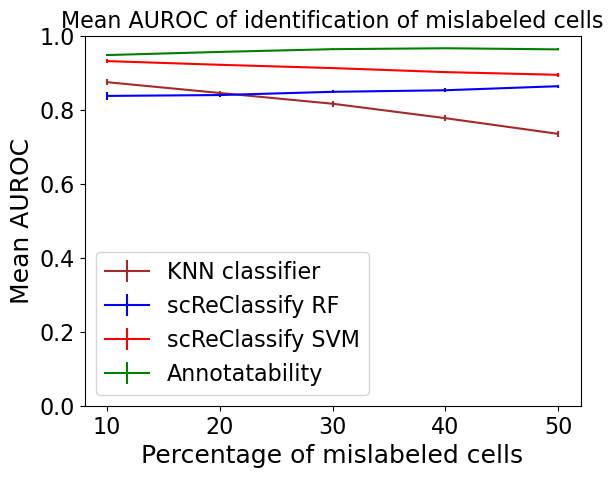

In [16]:
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_knn,
             yerr=np.sqrt(np.array(screc_res_list_knn_var)), color='brown',label='KNN classifier')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_rf,
             yerr=np.sqrt(np.array(screc_res_list_rf_var)), color='b',label='scReClassify RF')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_svm,
             yerr=np.sqrt(np.array(screc_res_list_svm_var)), color='r',label='scReClassify SVM')
plt.errorbar(np.arange(1,6)*0.1*100, cell_anno_list,
             yerr=np.sqrt(np.array(cell_anno_list_var)), color='g',label='Annotatability')
plt.ylim([0,1])
plt.title("Mean AUROC of identification of mislabeled cells", fontsize=16)
plt.xlabel("Percentage of mislabeled cells", fontsize=18)
plt.ylabel("Mean AUROC", fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [17]:
print(screc_res_list_knn)
print()
print(screc_res_list_rf)
print()
print(screc_res_list_svm)
print()
print(cell_anno_list)

[0.8753665746783753, 0.8461488202424011, 0.8171094884247679, 0.7780425350950224, 0.7356067480982764]

[0.8382384060615973, 0.8405708971507826, 0.8492939930185746, 0.8535427290683785, 0.8644784645428597]

[0.9324368120406884, 0.9223882745443797, 0.9134981830061928, 0.9026275739242327, 0.8953479267697178]

[0.94874849928069, 0.95729186570776, 0.9646875629859828, 0.967181912072013, 0.9641826009934613]


In [18]:
print(screc_res_list_rf_var)
print()
print(screc_res_list_svm_var)
print()
print(cell_anno_list_var)
print()
print(screc_res_list_knn_var)

[0.00010926505146505955, 2.1787293395457513e-05, 1.3970182586523902e-05, 3.193289563272161e-05, 1.9965192258520362e-05]

[3.773555764869449e-05, 7.597365865214288e-06, 1.2983953665475729e-05, 1.1886912411584641e-05, 2.3668283658526922e-05]

[1.4581435270811226e-05, 1.440314190742435e-05, 8.177031880812294e-06, 3.1979939962669703e-06, 6.133909971425239e-06]

[7.14156205351493e-05, 2.4397354541209756e-05, 7.23308872591567e-05, 5.517971593184741e-05, 6.086722583148857e-05]
